# <span style= "font-family: Papyrus; font_size: 5em; "> Twitter Sentiment Analysis ℹ️ 🅰️ Model</span>
<p>----------------------------------------------------------------------------------------------------------------- </p>

**Librairies**

In [32]:
import pandas as pd
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
warnings.filterwarnings("ignore")

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step 1 | Chargement des données </span>

**Description des données**

Le tableau suivant contient des commentaires associées à des sentiments exprimés sur le réseau social Twitter à propos de certain jeux videos, logiciel et application. Il sera utilisé pour entraîner et évaluer un modèle d'analyse de sentiment associé aux tweets grace aux RNN.

Le tableau comprend les colonnes suivantes :

1. **Technology**: cette colonne comprend des noms de jeux videos, applications et logiciels developpés.

2. **Sentiment**: Cette colonne représente la polarité du sentiment exprimé dans le texte. Elle peut prendre 4 valeurs :
   - Positive : correspond à un sentiment positif.
   - Negative : correspond à un sentiment negatif.
   - Neutral : correspond à un sentiment neutre.
   - Irrelevant : correspond à un sentiment non pertinent.

3. **Tweet**: Le texte du tweet ou du message exprimant le sentiment.


In [79]:
#ouverture du dataset
data = pd.read_csv('twitter.csv')
data

,Technology,Sentiment,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...
75677,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75680,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


**Information sur des données**

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Technology  75682 non-null  object
 1   Sentiment   75682 non-null  object
 2   Tweet       74996 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step2: | Prétraitement des données </span>

**Verification des valeurs manquantes**

In [81]:
# Affichage du bilan des valeurs manquantes
print(data.isnull().sum())

Technology      0
Sentiment       0
Tweet         686
dtype: int64


In [82]:
# suppression des valeurs manquantes 
data.dropna(inplace=True)
# verfication
print(data.isnull().sum())

Technology    0
Sentiment     0
Tweet         0
dtype: int64


**Verification des duplicats**

In [83]:
# check duplicate values
data.duplicated().sum()

3555

In [84]:
# remove duplicate values 
remove_duplicates = data.drop_duplicates()
data = remove_duplicates
# check duplicate values
data.duplicated().sum()

0

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; ">🔻Step3: | Visualisation des données </span>

**Distribution des sentiments dans le dataset**

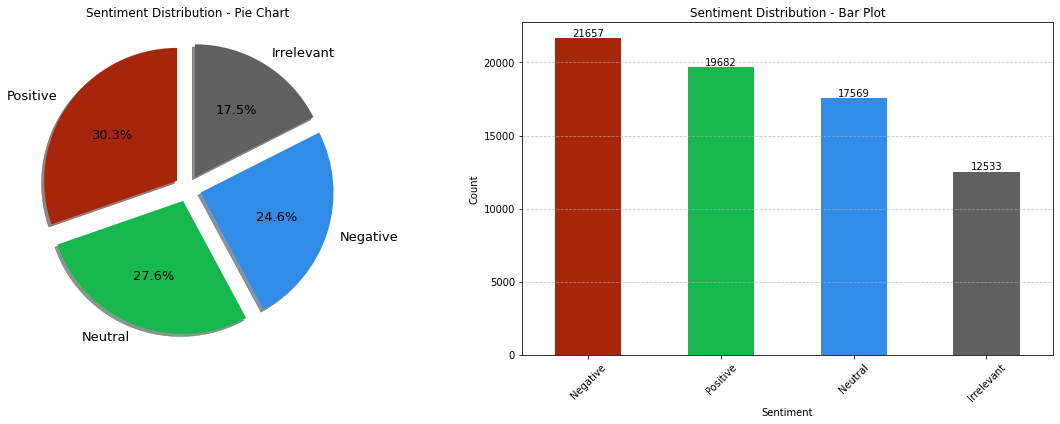

In [85]:
# Definir les couleurs
colors = ['#A5260A', '#16B84E', '#318CE7', '#606060']

# figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# diagramme circulaire pour la distribution des sentiments avec les couleurs definies
axs[0].pie(data['Sentiment'].value_counts(), labels=data['Sentiment'].unique(), autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 13},
            explode=[0.1, 0.1, 0.1, 0.1], colors=colors, shadow=True)
axs[0].set_title('Sentiment Distribution - Pie Chart')

# diagramme en bandes pour la distribution des sentiments
axs[1] = data['Sentiment'].value_counts().plot(kind='bar', color=colors, ax=axs[1])
axs[1].set_title('Sentiment Distribution - Bar Plot')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add text on top of each bar in the bar plot
for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

**Distribution des sentiments par Technologies**

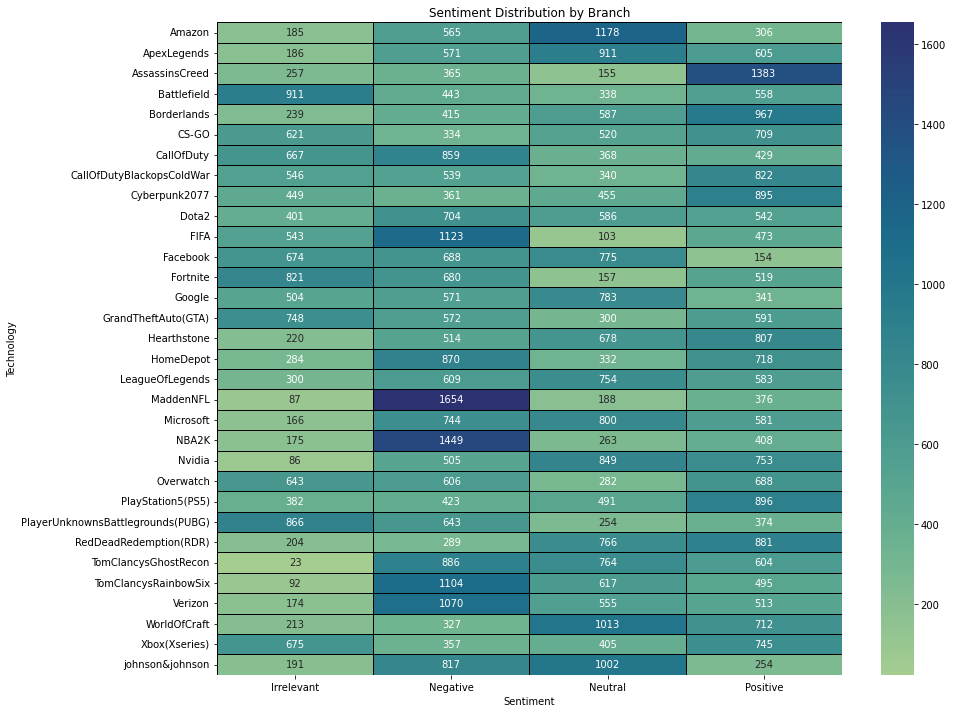

In [86]:
# Creation de la table croisee
count_table = pd.crosstab(index=data['Technology'], columns=data['Sentiment'])
# trace
plt.figure(figsize=(14, 12))
sns.heatmap(count_table, cmap="crest", fmt='d',linewidths=0.5, linecolor='black',annot = True)
plt.title('Sentiment Distribution by Branch')
plt.xlabel('Sentiment')
plt.ylabel('Technology')
plt.show()

> **Sentiment 'Non-pertinent':**                                                                                                     
Min: 23   -->    'TomClancysGhostRecon'                                                                               
Max: 911  -->  'Battlefield'                                                                                      
 **Sentiment 'Negatif':**                                                                                                        
Min: 289 --> 'RedDeadRedemption(RDR)'                                                                            
Max: 1654 --> 'MaddenNFL'                                                                                        
**Sentiment 'Neutre':**                                                                                                          
Min: 103 --> 'FIFA'                                                                                              
Max: 1178 --> 'Amazon'                                                                                          
**Sentiment 'Positif':**                                                                                                        
Min: 154 --> 'Facebook'                                                                                          
Max: 1383 --> 'AssassinsCreed'

**Nuage des Technologies**

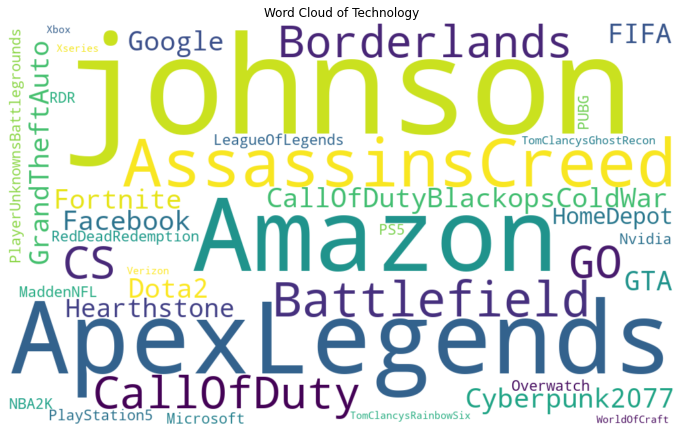

In [87]:
# Convertir les technologies en chaine de caracteres
branch = ' '.join(count_table.index)

# Create word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(branch)

# Plot word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Technology')
plt.axis('off')
plt.show()

**Nuage des Tweets**

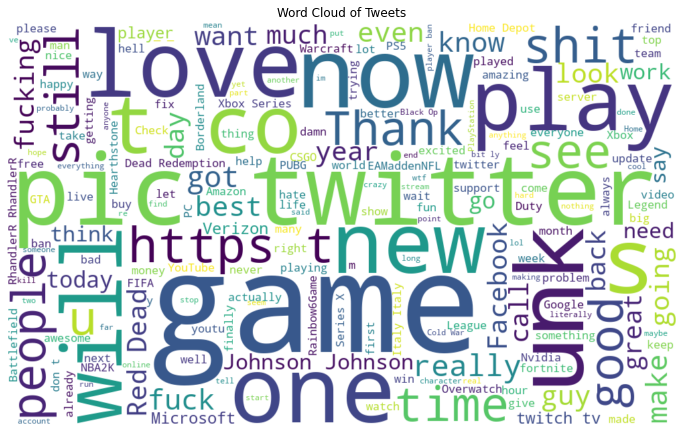

In [88]:
# Concatenate all tweets into a single string
all_tweets = ' '.join(data['Tweet'])

# Create word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(all_tweets)

# Plot word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step4: | Traitement des Tweets </span>

### <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 1.Preprocessing </span> 

**Conversion en miniscule**

Dans cette étape on convertit tout le texte en miniscule. cela aide au traitement des mots avec differentes casses et a reduire la taille du vocabulaire

Exemple: " I LOVE AssassinsCreed." -->  " i love assassinscreed."

In [18]:
def normalize_text(text):
    return text.lower()

**Retrait des caracteres qui ne sont pas alphabetiques**

Dans cette étape on supprime tous les caractères speciaux, les nombres car ces derniers sont non pertinents pour la tache

Exemple: "The product is priced at $99." --> "The product is priced at ."

In [90]:
def filter_non_string(df, column):
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

**Retrait des espaces blancs supplementaires**

Dans cette étape on supprime tous les espaces blancs supplementaires

In [91]:
def remove_white_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

**Retrait des tags html**

Dans cette étape on supprime tous les tags htmls car ils ne contribuent pas a l analyse

Exemple: " This is an >>important>> <<>>message." --> " This is an important message."

In [92]:
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

**Retrait des liens URL**

Dans cette étape on supprime tous les liens URL dans les commentaires car non pertinent

Exemple: "Check out this amazing website: www.example.com" --> "Check out this amazing website"

In [93]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

**Retrait des ponctuations**

Dans cette étape on supprime les ponctuations des commentaires

Exemple: " Facebook is an amazing website ! " --> "Facebook is an amazing website"

In [94]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

**Retrait des nombres**

Dans cette étape on supprime les nombres des commentaires car non pertinent

Exemple: " I have 10 apples " --> "I have apples"

In [24]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

**Retrait des emojis**

Dans cette étape on supprime les emojis des commentaires car ces derniers posent probleme lors de la vectorization

Exemple: " I'm feeling 😊 today. " --> " I'm feeling today."

In [95]:
def remove_emojis(text):
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

### <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 2.Tokenization </span> 

Cette etape consiste à involves decouper le texte en mots individuels ou tokens. Les Tokens vont servir d unites de base pour l analyse suivante.

Example: "I love natural language processing." -->   ["I", "love", "natural", "language", "processing"]


In [97]:
def tokenize_text(text):
    return word_tokenize(text)

**Eliminate Stop Words**

les Stop words sont largement utilisés comme: "le," "sur," or "et"...etc qui assure la coherence du texte et peuvent etre supprimes pour reduire les bruits dans les donnees lors de la tokenzination .

Exemple: "The quick brown fox jumps over the lazy dog." --> ["quick", "brown", "fox", "jumps", "lazy", "dog"]

In [96]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

**Detection et Traduction vers l'Anglais**

pour eviter les erreurs du au changement de langue

In [98]:
from langdetect import detect
from googletrans import Translator
def detect_trans(text):
    lang = detect(text)
    if lang != 'en':
        translator = Translator()
        text = translator.translate(text, dest='en').text
        return text
    else:
        return text

In [52]:
text = detect_trans("le soleil brille fort aujourdhui")
text

'the sun is shining brightly today'

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step5: | Application des traitements au dataset </span>

**Traitement**

In [99]:
def preprocess_text(df):
    df = filter_non_string(df, 'Tweet')
    df['Tweet'] = df['Tweet'].apply(normalize_text)
    df['Tweet'] = df['Tweet'].apply(remove_html_tags)
    df['Tweet'] = df['Tweet'].apply(remove_urls)
    df['Tweet'] = df['Tweet'].apply(remove_white_spaces)
    df['Tweet'] = df['Tweet'].apply(remove_numbers)
    df['Tweet'] = df['Tweet'].apply(remove_punctuation)
    df['Tweet'] = df['Tweet'].apply(remove_emojis)
    return df

In [100]:
# Usage:
data_processed = preprocess_text(data)
data_processed.head()

,Technology,Sentiment,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,i am coming to the borders and i will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you all
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands and i will murder y...


**Tokenization**

In [101]:
def token(df):
    df['Tweet'] = df['Tweet'].apply(tokenize_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    return df

In [102]:
# Usage:
data_token = token(data_processed)
data_token.head()

,Technology,Sentiment,Tweet
0,Borderlands,Positive,"[im, getting, borderlands, murder]"
1,Borderlands,Positive,"[coming, borders, kill]"
2,Borderlands,Positive,"[im, getting, borderlands, kill]"
3,Borderlands,Positive,"[im, coming, borderlands, murder]"
4,Borderlands,Positive,"[im, getting, borderlands, murder]"


**recuperation des features (X) et target (Y)**

In [103]:
X = data_token['Tweet']  # Features
Y = data_token['Sentiment']  # Target

**division des donnees en entrainement et test**

In [104]:
# 80% training, 20% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# Print the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", Y_train.shape)
print("Shape of y_test:", Y_test.shape)

Shape of X_train: (57152,)
Shape of X_test: (14289,)
Shape of y_train: (57152,)
Shape of y_test: (14289,)


**Vectorisation des donnees**

les donnees textuelles ont besoin d etre convertit en vecteurs numeriques pour les algoritmes de machine learning. plusieurs techniques comme Bag-of-Words, TF-IDF, or word embeddings peuvent etre utilisée our vectoriser un texte.

Exemple: ["I", "love", "OpenAI"]  --> [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...] (vector representation)

In [105]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)# Corrected spacing

the size of vocab = 35452


In [106]:
def vectorize_data(X, maxlen):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen = maxlen)
    return X

In [107]:
maxlen = 100
X_train = vectorize_data(X_train, maxlen)
X_test = vectorize_data(X_test, maxlen)

In [108]:
X_train

array([[    0,     0,     0, ...,   297,  1293,  1160],
       [    0,     0,     0, ...,   178,   205,   107],
       [    0,     0,     0, ...,     1,    19, 11801],
       ...,
       [    0,     0,     0, ...,    88, 17899,    84],
       [    0,     0,     0, ...,   541,  9896,  1782],
       [    0,     0,     0, ...,  1116,   459,   650]])

In [109]:
X_train.shape

(57152, 100)

**Encodage de la target**

In [110]:
# Encode Sentiment labels
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)

In [111]:
from tensorflow import keras
Y_train = keras.utils.to_categorical(Y_train, 4) #on precise le nombre de classes
Y_test = keras.utils.to_categorical(Y_test,4)

In [112]:
Y_train

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [113]:
Y_test.shape

(14289, 4)

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> Step6: | Construction du modele </span>

**LSTM**

In [94]:
model_lstm = Sequential()

model_lstm.add(Embedding(v+1, 100))
model_lstm.add(Dropout(0.25))

model_lstm.add(LSTM(100,dropout=0.25,recurrent_dropout=0.25))

model_lstm.add(Dense(50,activation='relu'))

model_lstm.add(Dense(25,activation='relu'))

model_lstm.add(Dense(4,activation='softmax'))

In [96]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         3544600   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 4)                 104       
                                                                 
Total params: 3631429 (13.85 MB)
Trainable params: 363

In [98]:
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step7: | Entrainement du modele </span>

In [100]:
history_lstm = model_lstm.fit(X_train,Y_train, epochs=20, validation_split = 0.1)

Epoch 1/20
1608/1608 [==============================] - 333s 207ms/step - loss: 0.9115 - accuracy: 0.6277 - val_loss: 0.6276 - val_accuracy: 0.7636
Epoch 2/20
1608/1608 [==============================] - 319s 199ms/step - loss: 0.4720 - accuracy: 0.8246 - val_loss: 0.4874 - val_accuracy: 0.8203
Epoch 3/20
1608/1608 [==============================] - 313s 195ms/step - loss: 0.3319 - accuracy: 0.8753 - val_loss: 0.4329 - val_accuracy: 0.8455
Epoch 4/20
1608/1608 [==============================] - 341s 212ms/step - loss: 0.2638 - accuracy: 0.9004 - val_loss: 0.4108 - val_accuracy: 0.8593
Epoch 5/20
1608/1608 [==============================] - 348s 216ms/step - loss: 0.2240 - accuracy: 0.9141 - val_loss: 0.4123 - val_accuracy: 0.8672
Epoch 6/20
1608/1608 [==============================] - 323s 201ms/step - loss: 0.1949 - accuracy: 0.9236 - val_loss: 0.4155 - val_accuracy: 0.8700
Epoch 7/20
1608/1608 [==============================] - 313s 195ms/step - loss: 0.1764 - accuracy: 0.9310 - val_

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step8: | Trace de la loss en entrainement et test </span>

In [101]:
def plot(history):
    
    # Plot training & validation loss values
    plt.figure(figsize=(20,5))
    ax1 = plt.subplot(1,3,1)
    ax1.plot(history.history['loss'], 'o-',label='Train')
    ax1.plot(history.history['val_loss'], 'o-', label='validation', c ='r')
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch') 
    ax1.grid()
    ax1.legend(loc='best')
    
    # Plot training & validation accuracy values
    ax2 = plt.subplot(1,3,2)
    ax2.plot(history.history['accuracy'], 'o-', label='Train')
    ax2.plot(history.history['val_accuracy'], 'o-',  label='validation')
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='best')
    ax2.grid()
    
    plt.show()

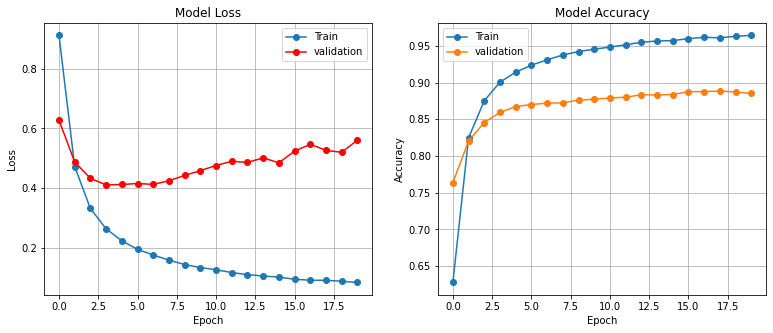

In [102]:
plot(history_lstm)

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step8: | Evaluation de la performance du modèle </span>

In [104]:
final_loss, final_acc = model_lstm.evaluate(X_test, Y_test, verbose=1)
print("Final Acurracy: {0:.4f} %".format(final_acc*100))
print("Final Precision: {0:.4f} %".format(final_acc*100))

447/447 [==============================] - 11s 24ms/step - loss: 0.6384 - accuracy: 0.8719
Final Acurracy: 87.1859 %
Final Precision: 87.1859 %


## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step9: | Prediction </span>

447/447 [==============================] - 10s 22ms/step


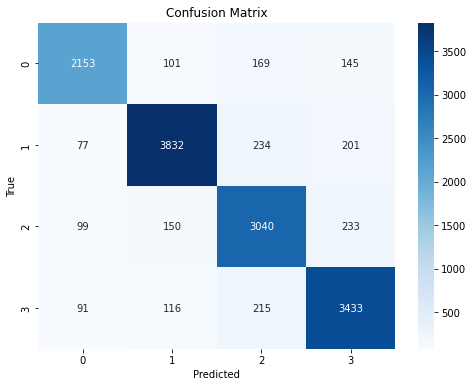

In [158]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred_probs = model_lstm.predict(X_test)

y_pred_labels = np.argmax(y_pred_probs, axis=1)
label_pred = label_encoder.inverse_transform(y_pred_labels)

y_true_labels = np.argmax(Y_test, axis=1)
label_true = label_encoder.inverse_transform(y_true_labels)

conf_matrix = confusion_matrix(label_true, label_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [154]:
label_pred

array(['Positive', 'Negative', 'Positive', 'Neutral'], dtype=object)

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step10: | Sauvegarde du modele </span>

In [11]:
model_lstm.save("model_lstm.keras")

## <span style= "font-family: Papyrus; font_size: 1em; font-style: underline; "> 🔻Step11: | test sur de nouvelles donnees </span>

In [13]:
from tensorflow.keras.models import load_model
model_tweet = load_model('model_lstm.keras')

In [56]:
def preprocess(text):
    text = detect_trans(text)
    text = normalize_text(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_white_spaces(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_emojis(text)
    return text

In [57]:
# Define a mapping between sentiment labels and emojis
sentiment_emojis = {
    'Positive': '😄',
    'Negative': '😞',
    'Neutral': '😐',
    'Irrelevant': '🤷‍♂️'
}

In [126]:
# Example tweets
example_tweets = [
    "le soleil brille fort aujourd'hui!!! ",
    "I just finished playing Borderlands and it was absolutely amazing! Can't wait for the next one!",
    "I'm really disappointed with the latest Borderlands update. It ruined the game for me.",
    "Haven't played Borderlands in a while. Need to catch up on the latest updates.",
    "Just saw a funny cat video while searching for Borderlands gameplay. Cats always cheer me up!",
    "pas de commentaires"
]


In [127]:
example_tweets_process = []

for tweet in example_tweets:
    tweet = preprocess(tweet)
    tweet = tokenize_text(tweet)
    tweet = remove_stopwords(tweet)
    example_tweets_process.append(tweet)
    
for t in example_tweets_process:
    print(t)

['sun', 'shining', 'brightly', 'today']
['finished', 'playing', 'borderlands', 'absolutely', 'amazing', 'cant', 'wait', 'next', 'one']
['im', 'really', 'disappointed', 'latest', 'borderlands', 'update', 'ruined', 'game']
['havent', 'played', 'borderlands', 'need', 'catch', 'latest', 'updates']
['saw', 'funny', 'cat', 'video', 'searching', 'borderlands', 'gameplay', 'cats', 'always', 'cheer']
['comments']


In [128]:
maxlen = 100
tweet_vect = vectorize_data(example_tweets_process, maxlen)

y_pred_probs = model_tweet.predict(tweet_vect)

y_pred_labels = np.argmax(y_pred_probs, axis=1)

label_pred_tweet = label_encoder.inverse_transform(y_pred_labels)

# Print the predicted sentiment and corresponding emoji for each example tweet
print('*****************prediction*******************')
for tweet, sentiment in zip(example_tweets, label_pred_tweet):
    emoji = sentiment_emojis[sentiment]  # Get the emoji directly from the mapping without a default value
    print('--------------------------------------------------')
    print("Tweet:", tweet)
    print(f"Sentiment:{sentiment} ---> Emoji:{emoji} " )
    print()
    print()

1/1 [==============================] - 0s 44ms/step
*****************prediction*******************
--------------------------------------------------
Tweet: le soleil brille fort aujourd'hui!!! 
Sentiment:Neutral ---> Emoji:😐 


--------------------------------------------------
Tweet: I just finished playing Borderlands and it was absolutely amazing! Can't wait for the next one!
Sentiment:Positive ---> Emoji:😄 


--------------------------------------------------
Tweet: I'm really disappointed with the latest Borderlands update. It ruined the game for me.
Sentiment:Positive ---> Emoji:😄 


--------------------------------------------------
Tweet: Haven't played Borderlands in a while. Need to catch up on the latest updates.
Sentiment:Positive ---> Emoji:😄 


--------------------------------------------------
Tweet: Just saw a funny cat video while searching for Borderlands gameplay. Cats always cheer me up!
Sentiment:Negative ---> Emoji:😞 


-------------------------------------------